In [1]:
from IPython.display import clear_output

!pip install --upgrade tensorflow
!pip install --upgrade keras

!pip install plotly
!pip install glob2

clear_output()
print("Tensorflow and Keras are Updated. Plotly and Glob are installed.")

Tensorflow and Keras are Updated. Plotly and Glob are installed.


In [2]:
from IPython.display import clear_output

import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
path1 = glob('/kaggle/input/arlp-datasets/ARLP Datasets ver-2/train/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path1:
    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [5]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df

filepath  xmin  xmax  ymin  \
0     /kaggle/input/arlp-datasets/ARLP Datasets ver-...   209   283   135   
1     /kaggle/input/arlp-datasets/ARLP Datasets ver-...   191   242   147   
2     /kaggle/input/arlp-datasets/ARLP Datasets ver-...   244   369   240   
3     /kaggle/input/arlp-datasets/ARLP Datasets ver-...   331   538   263   
4     /kaggle/input/arlp-datasets/ARLP Datasets ver-...   115   277   115   
...                                                 ...   ...   ...   ...   
1220  /kaggle/input/arlp-datasets/ARLP Datasets ver-...   354   656   481   
1221  /kaggle/input/arlp-datasets/ARLP Datasets ver-...   622   789   726   
1222  /kaggle/input/arlp-datasets/ARLP Datasets ver-...   257   499   704   
1223  /kaggle/input/arlp-datasets/ARLP Datasets ver-...    38   146   225   
1224  /kaggle/input/arlp-datasets/ARLP Datasets ver-...   321   559   420   

      ymax  
0      169  
1      169  
2      293  
3      317  
4      153  
...    ...  
1220   564  
1221   875  
1222   759  
1223   249  
1224   484  

[1225 rows x 5 columns]

In [ ]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('/kaggle/input/arlp-datasets/ARLP Datasets ver-2/train',filename_image)
    return filepath_image
getFilename(filename)

'/kaggle/input/arlp-datasets/ARLP Datasets ver-2/train/Cars339.png'

In [7]:
image_path = list(df['filepath'].apply(getFilename))
# image_path = image_path
# image_path = image_path[:25]

# Pre-processing

In [8]:
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape

    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0

    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax)

    data.append(norm_load_image_arr)
    output.append(label_norm)

In [9]:
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [10]:
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((980, 224, 224, 3), (245, 224, 224, 3), (980, 4), (245, 4))

# Using Inception ResNet V2 (Transfer Learning)

In [11]:
inception_resnet = InceptionResNetV2(weights="imagenet",
                                     include_top=False,
                                     input_tensor=Input(shape=(224,224,3)))

headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(512,activation="relu")(headmodel)
headmodel = Dense(256,activation="relu")(headmodel)
headmodel = Dense(4,activation='sigmoid')(headmodel)

model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

model.name = "ARLP_Inception_model"
model.summary()

Model: "ARLP_Inception_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 74,130,404 (282.79 MB)

 Trainable params: 74,069,860 (282.55 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [13]:
total_params = model.count_params()
print("Total number of parameters:", total_params)

total_size_mb = total_params * 4 / (1024 * 1024)
print("Rough estimation of model size:", total_size_mb, "MB")

Total number of parameters: 74130404
Rough estimation of model size: 282.78504943847656 MB


In [16]:
# x_train = x_train[:10]
# y_train = y_train[:10]
BATCHSIZE = 10
EPOCHS = 200

In [ ]:
history = model.fit(x=x_train,
                    y=y_train,
                    batch_size=BATCHSIZE,
                    epochs=EPOCHS,
                    validation_data=(x_test,y_test))

Epoch 1/200


I0000 00:00:1714974503.095670     132 service.cc:145] XLA service 0x789e68004a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714974503.095719     132 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1714974575.640549     132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 ━━━━━━━━━━━━━━━━━━━━ 191s 349ms/step - accuracy: 0.6094 - loss: 0.0479 - val_accuracy: 0.8367 - val_loss: 0.0118
Epoch 2/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.8295 - loss: 0.0068 - val_accuracy: 0.8653 - val_loss: 0.0074
Epoch 3/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.8975 - loss: 0.0029 - val_accuracy: 0.8531 - val_loss: 0.0094
Epoch 4/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.9220 - loss: 0.0024 - val_accuracy: 0.9306 - val_loss: 0.0092
Epoch 5/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.9291 - loss: 0.0021 - val_accuracy: 0.9020 - val_loss: 0.0097
Epoch 6/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.9375 - loss: 0.0014 - val_accuracy: 0.8980 - val_loss: 0.0088
Epoch 7/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.9329 - loss: 0.0016 - val_accuracy: 0.8816 - val_loss: 0.0090
Epoch 8/200
98/98 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.9434 - loss: 9.1990e-04 - val_acc

# Model Analysis

8/8 - 15s - 2s/step - accuracy: 0.9429 - loss: 0.0040


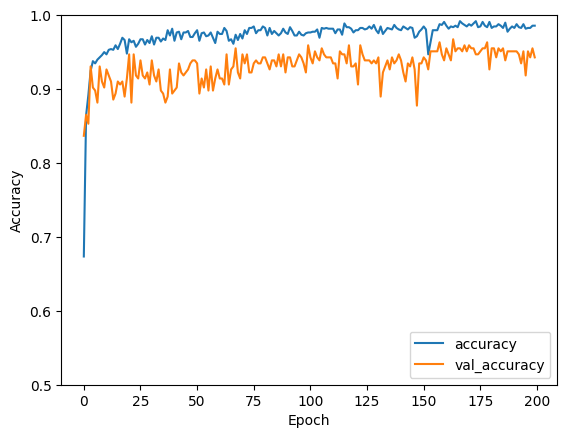

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

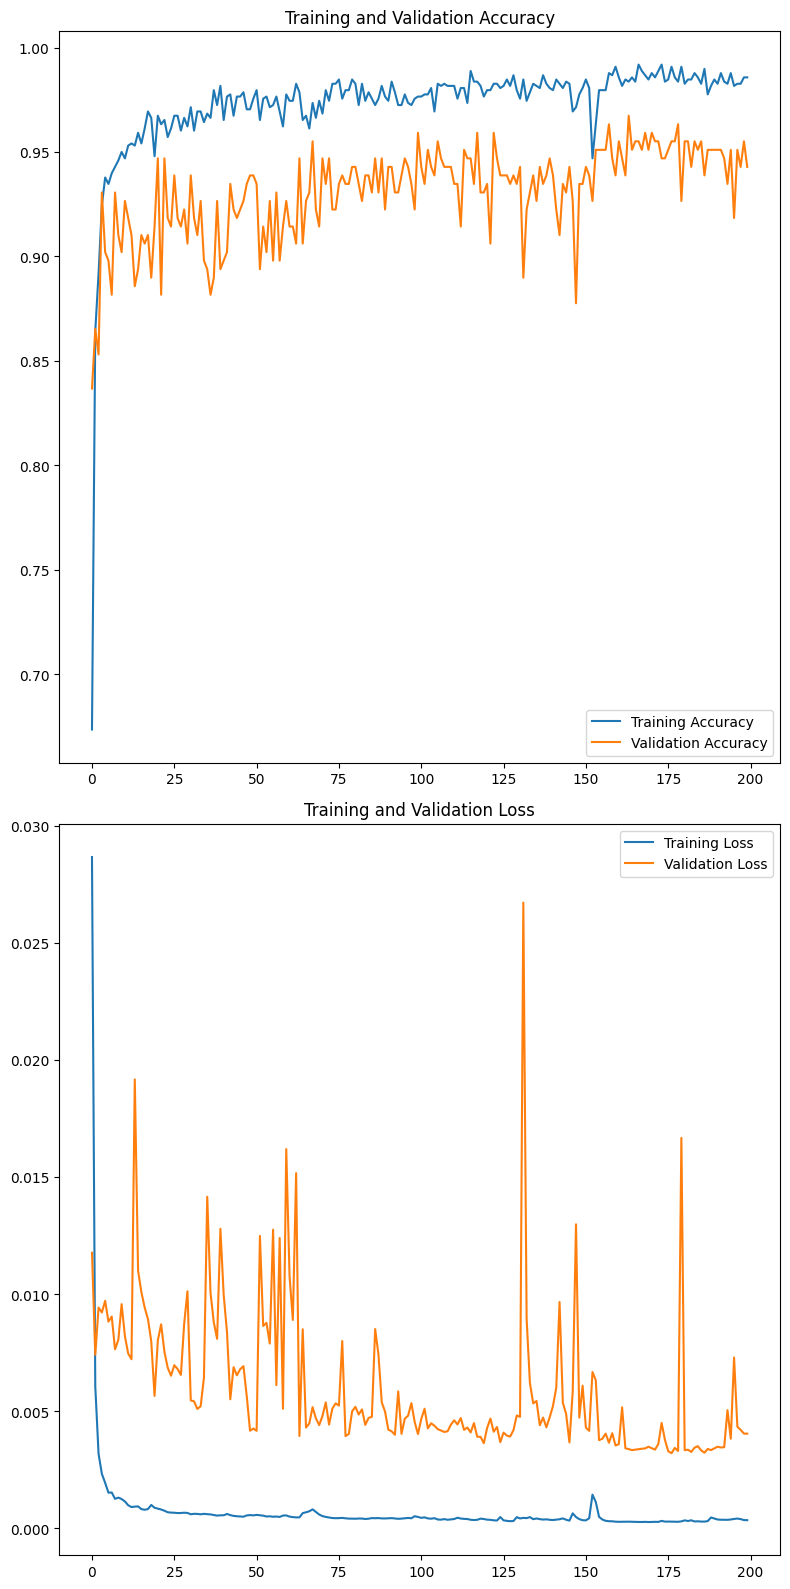

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 16))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [23]:
print(f"The accuracy of this model is: {100 * test_acc} %")

The accuracy of this model is: 94.28571462631226 %


# Saving the Model

In [24]:
model.save('./ARLP_InceptionResNet.keras')
# model.save('./ARLP_InceptionResNet.h5')

------------------

# Testing the Model

In [25]:
model = tf.keras.models.load_model('./ARLP_InceptionResNet.keras')
model.summary()

Model: "ARLP_Inception_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 222,270,126 (847.89 MB)

 Trainable params: 74,069,860 (282.55 MB)

 Non-trainable params: 60,544 (236.50 KB)

 Optimizer params: 148,139,722 (565.11 MB)

In [29]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='ARLP_Inception_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
path = '/kaggle/input/arlp-datasets/ARLP Datasets ver-2/train/143.jpg'
def object_detection(path):

    image = load_img(path)
    image = np.array(image,dtype=np.uint8)
    image1 = load_img(path,target_size=(224,224))

    image_arr_224 = img_to_array(image1)/255.0
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)

    coords = model.predict(test_arr)

    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)

    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
(794, 362) (979, 470)


In [30]:
# Cropping
img = np.array(load_img(path))
xmin,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10))